Обобщение для общего случая входных изображений

In [5]:
import cv2
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
def convert_to_grayscale(path):

    image = np.float32(cv2.imread(path))
    sz = image.shape
    values=np.zeros((image.shape[0],image.shape[1]))
    if (len(sz) == 3):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                values[i][j] = (image[i][j][0]  + image[i][j][1]  + image[i][j][2])/3
    else:
        values = image;

    values = values/np.max(values)

    return values

In [9]:
path1 = r'/Users/danil/Documents/Python projects/Non Square Fields/first.png'
path2 = r'/Users/danil/Documents/Python projects/Non Square Fields/second.png'

first=convert_to_grayscale(path1)
second=convert_to_grayscale(path2)

In [43]:
delta_t=1  # достаточно малое значение времени △T
c_x=5      # начальное приближение для горизонтального сдвига
c_y=5      # начальное приближение для вертикального сдвига

A0=[[0.0,0.0],[0.0,0.0]]  #первое приближение для матрицы параметров А
c0=[c_x, c_y]             #первое приближение для вектора с
time_direct  = np.linspace(0, delta_t) #дискретизация времени для интегрирования (на выходне получаем массив чисел от 0 до delta_t, которое задаем вручную - в этом случае равно 1)
time_reverse = np.linspace(delta_t, 0) #дискретизация времени для обратного интегрирования (аналогичный массив чисел, но от delta_t до 0)
alpha=0.01 #шаг градиентного спуска

In [44]:
#интегрирование системы (14)
def dx_dt(A,c,x0,time):
    def F(x,t):
        dx1dt=A[0][0]*x[0]+A[0][1]*x[1]+c[0]
        dx2dt=A[1][0]*x[0]+A[1][1]*x[1]+c[1]
        return [dx1dt,dx2dt]
    solution = odeint(F,x0,time)
    return solution

In [45]:
#закон смещения каждого пикселя
def xT(A,c):
    x1_T=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    x2_T=np.array([[0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    for i in range(first.shape[0]):
        for j in range(first.shape[1]):
            x0=[j,i]
            solution=dx_dt(A,c,x0,time_direct)
            x1_T[i][j]=int(round(solution[int(time_direct.shape[0]-1)][0]))
            x2_T[i][j]=int(round(solution[int(time_direct.shape[0]-1)][1]))

    return x1_T, x2_T

In [46]:
def rho_recalculated(x1,x2):
    rho_recalc=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    for i in range(second.shape[0]):
        for j in range(second.shape[1]):
            if(x2[i][j]<=first.shape[0]-1 and x2[i][j]>=0 and x1[i][j]<=first.shape[1]-1 and x1[i][j]>=0):
                rho_recalc[x2[i][j]][x1[i][j]]=first[i][j]

    return rho_recalc

In [50]:
#вычисление частной производной partial_rho/partial_x
def drho_dx(rho):
    drho_dx1=np.zeros((np.shape(rho)[0], np.shape(rho)[1]))
    drho_dx2=np.zeros((np.shape(rho)[0], np.shape(rho)[1]))
    for i in range(1,np.shape(rho)[0]-1):
        for j in range(1,np.shape(rho)[1]-1):
            drho_dx1[i][j]=-rho[i-1][j-1]-2*rho[i][j-1]-rho[i+1][j-1]+rho[i-1][j+1]+2*rho[i][j+1]+rho[i+1][j+1]
            drho_dx2[i][j]=-rho[i-1][j-1]-2*rho[i-1][j]-rho[i-1][j+1]+rho[i+1][j-1]+2*rho[i+1][j]+rho[i+1][j+1]
    return [drho_dx1, drho_dx2]

In [59]:
# p(T,x(T))-p̂(x(T))
def difference(x1,x2):
    diff=np.zeros((np.shape(first)[0], np.shape(first)[1]))
    diff=rho_recalculated(x1,x2)-second
    return diff

In [60]:
#вычисление ψ*
dsecond_dx=drho_dx(second)
def psi_star(x1,x2):
    psiT_1=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    psiT_2=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    psiT_1=2*difference(x1,x2)*dsecond_dx[0]
    psiT_2=2*difference(x1,x2)*dsecond_dx[1]
    return psiT_1, psiT_2

In [66]:
#интегрирование системы (18) в опратном порядке - поэтому выносим минус
def dPsi_dt(A,Psi0,time):
    def F(Psi,t):
        dPsi1dt=Psi[0]*A[0][0]+Psi[1]*A[0][1]
        dPsi2dt=Psi[0]*A[1][0]+Psi[1]*A[1][1]
        return [dPsi1dt,dPsi2dt]
    solution = odeint(F,Psi0,time)
    return solution

In [67]:
#ψ0 для каждого пикселя
def Psi0(A, psiT_1, psiT_2):
    Psi1_t0=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])
    Psi2_t0=np.array([[0.0 for col in range(first.shape[1])] for row in range(first.shape[0])])

    for i in range(first.shape[0]):
        for j in range(first.shape[1]):
            PsiT=[psiT_1[i][j],psiT_2[i][j]]
            solution_1=dPsi_dt(A,PsiT,time_reverse)
            Psi1_t0[i][j]=solution_1[49][0]
            Psi2_t0[i][j]=solution_1[49][1]

    return Psi1_t0, Psi2_t0

In [68]:
# partial_J/partial_c
def dJ_dc(psiT_1,psiT_2,Psi1_t0, Psi2_t0,time):
    dJ_dc1=0.0
    dJ_dc2=0.0

    dJ_dc1=-np.sum((psiT_1+Psi1_t0))*time/2
    dJ_dc2=-np.sum((psiT_2+Psi2_t0))*time/2

    return [dJ_dc1, dJ_dc2]

In [69]:
def gradient_descent(steps_num):
    C=[]
    x_T=[]
    PsiT=[]
    Psit0=[]
    dJdC=[]
    C_next=[]

    c_curr=c0
    C.append(c0)
    for i in range(steps_num):
        c_next=[0.0,0.0]
        x1_T, x2_T=xT(A0, c_curr)
        x_T.append([x1_T,x2_T])

        psiT_1,psiT_2=psi_star(x1_T, x2_T)
        PsiT.append([psiT_1,psiT_2])

        Psi1_t0, Psi2_t0=Psi0(A0,psiT_1,psiT_2)
        Psit0.append([Psi1_t0,Psi2_t0])

        dJdc=dJ_dc(psiT_1,psiT_2,Psi1_t0, Psi2_t0,delta_t)
        dJdC.append(dJdc)

        c_next[0]=c_curr[0]-alpha*dJdc[0]
        c_next[1]=c_curr[1]-alpha*dJdc[1]
        C_next.append(c_next)

        c_curr=c_next
        C.append(c_curr)

    return c_curr, C, x_T, PsiT, Psit0, dJdC, C_next

In [70]:
c_curr, C, x_T, PsiT, Psit0, dJdC, C_next=gradient_descent(20)

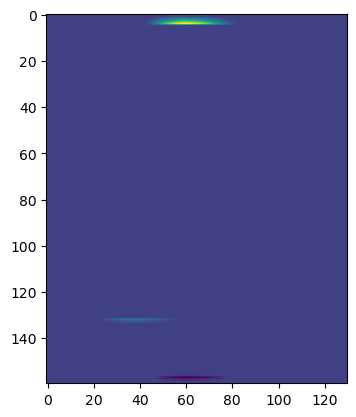

In [71]:
plt.imshow(rho_recalculated(x_T[19][0], x_T[19][1])-second)

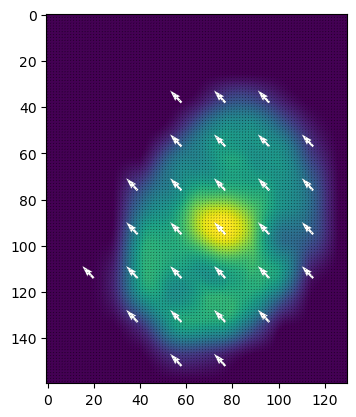

In [72]:
#first -> second
for i in range(0,first.shape[0],19):
    for j in range(0,first.shape[1],19):
        if first[i][j]!=0.0:
            plt.quiver(j+1,i, c_curr[0], -c_curr[1], color=(1,1,1));

x,y=np.meshgrid(np.linspace(0,first.shape[0],first.shape[1]),np.linspace(0,first.shape[0],first.shape[1]))
plt.quiver(x,y, 0.01,0.01);



# plt.quiver(x,y, A0[0][0]*x + A0[0][1]*y + c_curr[0], A0[1][0]*x + A0[1][1]*y + c_curr[1]);
plt.imshow(first)

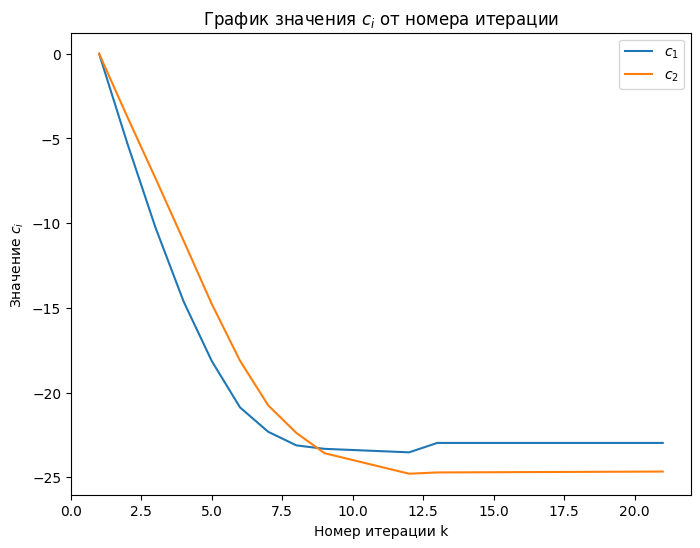

In [20]:
c1=[0.0]*len(C)
c2=[0.0]*len(C)

for i in range(len(C)):
  c1[i]=C[i][0]
  c2[i]=C[i][1]

num_iter=np.linspace(1,len(C), len(C))


fig, ax = plt.subplots(figsize=(8, 6))

plt.title(r'График значения $c_{i}$ от номера итерации') # заголовок
ax.set_xlabel("Номер итерации k") # ось абсцисс
plt.ylabel("Значение $c_{i}$") # ось ординат
ax.plot(num_iter, c1, label="$c_{1}$")
ax.plot(num_iter, c2, label="$c_{2}$")
ax.legend()

plt.show()

In [21]:
dJdc1=[0.0]*len(dJdC)
dJdc2=[0.0]*len(dJdC)

for i in range(len(dJdC)):
  dJdc1[i]=dJdC[i][0]
  dJdc2[i]=dJdC[i][1]

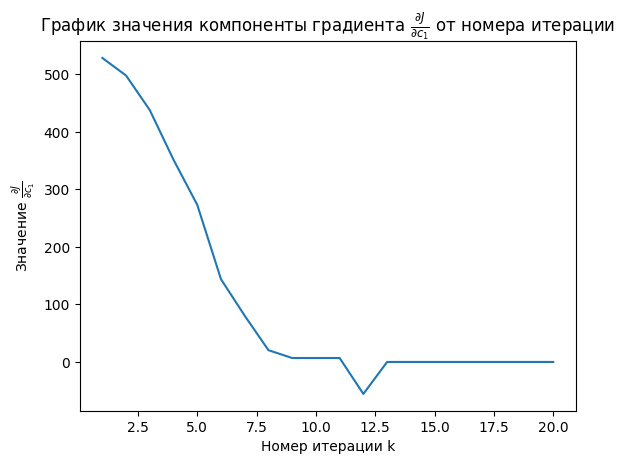

In [22]:
num_iter=np.linspace(1,len(dJdC), len(dJdC))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{1}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{1}}$') # ось ординат
plt.plot(num_iter,dJdc1,color='#1f77b4')

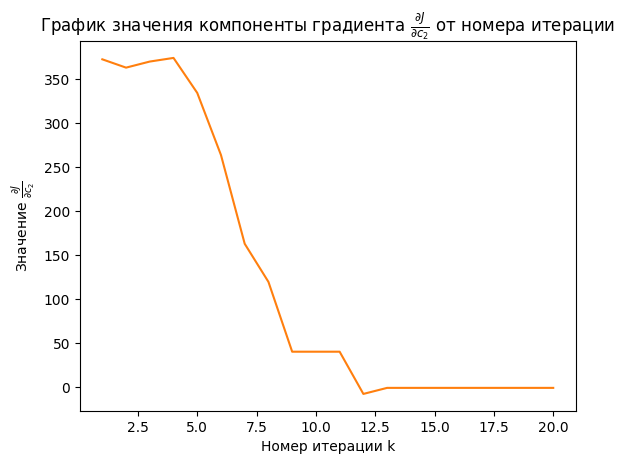

In [23]:
num_iter=np.linspace(1,len(dJdC), len(dJdC))
plt.title(r'График значения компоненты градиента $\frac{\partial J}{\partial c_{2}}$ от номера итерации') # заголовок
plt.xlabel("Номер итерации k") # ось абсцисс
plt.ylabel(r'Значение $\frac{\partial J}{\partial c_{2}}$') # ось ординат
plt.plot(num_iter,dJdc2,color='#ff7f0e')

In [ ]:
plt.imshow(rho_recalculated(x_T[26][0],x_T[26][1])-first)

IndexError: ignored

In [ ]:
C

In [ ]:
dJdC

In [ ]:
plt.imshow(second)

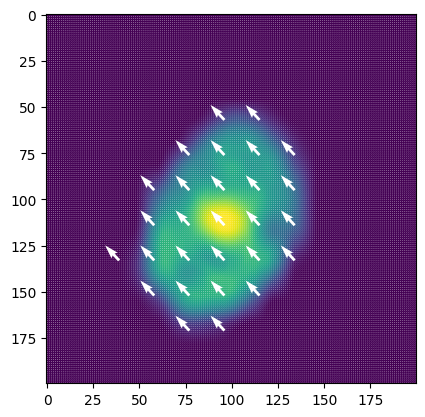

In [ ]:
k=15
#first -> second
for i in range(0,199,19):
    for j in range(0,199,19):
        if first[i][j]!=0.0:
            plt.quiver(j+1,i, C[k][0], -C[k][1], color=(1,1,1));

x,y=np.meshgrid(np.linspace(0,199,180),np.linspace(0,199,180))
plt.quiver(x,y, 0.1,0.1, color=(1,1,1));



# plt.quiver(x,y, A0[0][0]*x + A0[0][1]*y + c_curr[0], A0[1][0]*x + A0[1][1]*y + c_curr[1]);
plt.imshow(first)

In [ ]:
C[k]

[-22.969949369900462, -24.69228413003546]

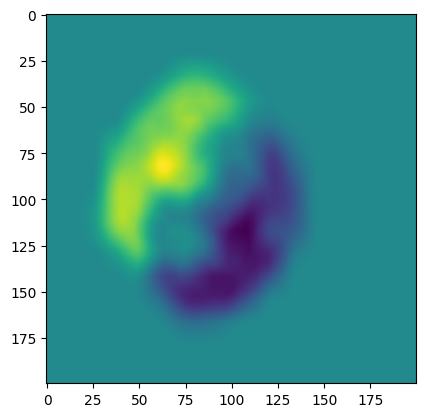

In [ ]:
plt.imshow(rho_recalculated(x_T[k][0],x_T[k][1])-first)

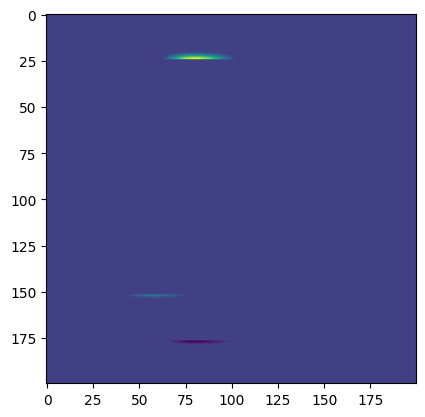

In [ ]:
plt.imshow(rho_recalculated(x_T[k][0],x_T[k][1])-second)

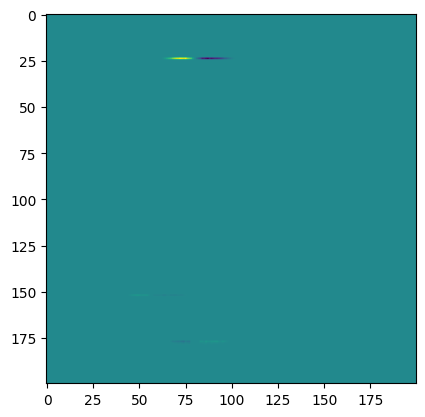

In [ ]:
plt.imshow(Psit0[29][0])